# Build a classificator for the Fashion MNIST dataset

Now we will build a classificator for the fashion MNIST dataset. In the words of the author:

"Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes. We intend Fashion-MNIST to serve as a direct drop-in replacement for the original MNIST dataset for benchmarking machine learning algorithms. It shares the same image size and structure of training and testing splits."

to download the dataset you can clone github repo with the command:
```
!git clone git@github.com:zalandoresearch/fashion-mnist.git
```

Or you can use the function in [torchvision](https://pytorch.org/vision/stable/datasets.html#fashion-mnist).

This practice will be free, and use of the documentation, working in groups and asking the instructor is encouraged. At the end you should build and test your model which needs to be reproductible in another computer. This problem have the following requirements:

1.   You should build two models: One an MLP and the other a CNN.
2.   You should use both models on MNIST and Fashion-MNIST.
3.   In the MLP model, keeping all the parameters the same, study the effect of increasing the number of layers of the network, use 2, 4 and 8 hidden layers. Make a graph of the accuray respect to the number of layers for both MNIST and Fashion-MNIST.
4.   Your can use batchNorm, dropout or any other techique that helps
 the number of layers and parameters of convolutions is free too.
5.   Use both SGD and SGD with momentum optimizer in the MLP an CNN, make a graph comparing the training loss curve with both optimizers for both datasets.
6.   Feel free to work in groups, search the web and ask questions but reporting remains individual.
7.   The metric to be used is accuracy but you can use as loss function binary cross entropy as before or any other.
8.   You must include the code of everything you did which should give all of the results.

At the end you should write a report containing the following:

*   The training and validations curves of both models for the two datasets.
*   The graph comparing the effect of number of layers in the MLP for the two datastes.
*   The graph comparing the effect of optimizer descibred in (5).
*   A table of accuracy containing rows for the dataset and colummns of model.
*   A table summarizing the hyperparameters used for both models.

At the end we will make a leaderboard to see who could design a model that achieves the highest accuracy for Fashion-MNIST.



In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
#MLP for classification

def layers(depth,width):
  layers = []
  layers.append(nn.Linear(28**2,width))
  layers.append(nn.ReLU())
  for i in range(depth-1):
    layers.append(nn.Linear(width,width))
    layers.append(nn.ReLU())
  layers.append(nn.Linear(width,10))
  layers.append(nn.Softmax(dim=1))
  return layers

class mlp(nn.Module):
  def __init__(self, depth, width):
    super(mlp,self).__init__()
    self.model = nn.Sequential(*layers(depth,width))
  def forward(self,x):
    x = torch.flatten(x,1)
    return self.model(x)

In [ ]:
#Build your CNN model
class cnn(nn.Module):
  def __init__(self):
    super(cnn,self).__init__()
    self.feature_extraction = nn.Sequential(
        nn.Conv2d(1,16,kernel_size=3,stride=1,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(16,32,kernel_size=3,stride=1,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
    )
    self.fc = nn.Sequential(
        nn.Linear(32*7*7,10),
        nn.Softmax(dim=1)
    )
  def forward(self,x):
    x = self.feature_extraction(x)
    x = torch.flatten(x,1)
    return self.fc(x)

In [ ]:
#Hyperparameters
batch_size = 64
n_epochs = 20
learn_rate = 1e-1
depth = 4            # This controls the number of layers of the MLP
dataset = 'FMNIST'    # MNIST or FMNIST
opt = 'sgd_momentum' # sgd or sgd_momentum
momentum = 0.9 
model_type = 'cnn' #choose betwen mlp or cnn

In [ ]:
#Use GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
#Dataset
if dataset == 'MNIST':
  transform = torchvision.transforms.ToTensor
  train_dataset = datasets.MNIST(root='./',download=True, train=True, transform=transform())
  test_dataset = datasets.MNIST(root='./', train=False, transform=transform())
if dataset == 'FMNIST':
  transform = torchvision.transforms.ToTensor
  train_dataset = datasets.FashionMNIST(root='./',download=True, train=True, transform=transform())
  test_dataset = datasets.FashionMNIST(root='./', train=False, transform=transform())

In [ ]:
if model_type == 'mlp':
  model = mlp(depth=depth,width=32).to(device)
if model_type == 'cnn':
  model = cnn().to(device)
print(model)

NameError: ignored

In [ ]:
#DataLoaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

In [ ]:
#Loss function and Optimizer
criterion = nn.BCELoss()
if opt == 'sgd':
  optimizer = torch.optim.SGD(model.parameters(),lr=learn_rate)
if opt == 'sgd_momentum':
  optimizer = torch.optim.SGD(model.parameters(),lr=learn_rate, momentum=momentum)

In [ ]:
#Training Loop
train_loss = []
val_loss = []
metric = []
for epoch in range(n_epochs):  # loop over the dataset multiple times
    epoch_loss = 0.0
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = F.one_hot(labels,10).type_as(inputs)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        # print statistics
        running_loss += loss.item()

        if i % 50 == 49:    # print every 50 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 50))
            running_loss = 0.0
    train_loss.append(epoch_loss/(i+1))
    #Evaluation of the trained model
    correct = 0
    total = 0
    epoch_loss = 0.0
    print("validating...")
    with torch.no_grad():
        for i, data in enumerate(test_loader, 0):
            inputs, labels = data
            inputs = inputs.to(device)
            outputs = model(inputs)
            predicted = torch.argmax(outputs,dim=1)
            loss = criterion(outputs, F.one_hot(labels,10).type_as(inputs))
            labels =  labels.type_as(inputs)
            total += labels.shape[0]
            correct += (predicted == labels).sum().item()
            epoch_loss += loss.item()
    accuracy = 100 * correct / total
    print('Accuracy of the network on the test images: %d %%' % (accuracy))
    metric.append(accuracy)
    val_loss.append(epoch_loss/(i+1))
if model_type=='mlp':
  torch.save(metric,model_type + '_metric_'+ dataset +'_'+ opt + '_'+ str(depth)+'_layers.py')
  torch.save(train_loss,model_type + '_loss_'+ dataset +'_'+ opt + '_' + str(depth)+'_layers.py')
if model_type=='cnn':
  torch.save(metric,model_type + '_metric_'+ dataset +'_'+ opt +'.py')
  torch.save(train_loss,model_type + '_loss_'+ dataset +'_'+ opt +'.py')
print('Finished Training')

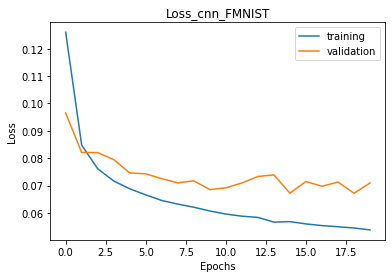

In [ ]:
plt.plot(train_loss, label='training')
plt.plot(val_loss, label='validation')
plt.legend()
plt.title('Loss_'+model_type+'_'+dataset)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.savefig('Loss_'+model_type+'.png')

In [ ]:
metric1 = torch.load('/content/mlp_metric_MNIST_sgd_2_layers.py')
metric2 = torch.load('/content/mlp_metric_MNIST_sgd_4_layers.py')
metric3 = torch.load('/content/mlp_metric_MNIST_sgd_6_layers.py')

plt.plot(metric1, label='2 layers')
plt.plot(metric2, label='4_layers')
plt.plot(metric3, label='6_layers')
plt.legend()
plt.title('Accuracy MNIST')


FileNotFoundError: ignored

In [ ]:
metric1 = torch.load('/content/mlp_metric_FMNIST_sgd_2_layers.py')
metric2 = torch.load('/content/mlp_metric_FMNIST_sgd_4_layers.py')
metric3 = torch.load('/content/mlp_metric_FMNIST_sgd_6_layers.py')

plt.plot(metric1, label='2 layers')
plt.plot(metric2, label='4_layers')
plt.plot(metric3, label='6_layers')
plt.legend()
plt.title('Accuracy Fashion MNIST')


FileNotFoundError: ignored

In [ ]:
metric1 = torch.load('/content/mlp_metric_MNIST_sgd_4_layers.py')
metric2 = torch.load('/content/mlp_metric_MNIST_sgd_momentum_4_layers.py')
loss1 = torch.load('/content/mlp_loss_MNIST_sgd_4_layers.py')
loss2 = torch.load('/content/mlp_loss_MNIST_sgd_momentum_4_layers.py')
fig = plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(metric1, label='sgd')
plt.plot(metric2, label='sgd_momentum')
plt.legend()
plt.title('Accuracy MNIST '+model_type)

plt.subplot(1,2,2)
plt.plot(loss1, label='sgd')
plt.plot(loss2, label='sgd_momentum')
plt.legend()
plt.title('training loss MNIST '+model_type)

FileNotFoundError: ignored

In [ ]:
metric1 = torch.load('/content/mlp_metric_FMNIST_sgd_4_layers.py')
metric2 = torch.load('/content/mlp_metric_FMNIST_sgd_momentum_4_layers.py')
loss1 = torch.load('/content/mlp_loss_FMNIST_sgd_4_layers.py')
loss2 = torch.load('/content/mlp_loss_FMNIST_sgd_momentum_4_layers.py')
fig = plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(metric1, label='sgd')
plt.plot(metric2, label='sgd_momentum')
plt.legend()
plt.title('Accuracy Fashion MNIST '+model_type)


plt.subplot(1,2,2)
plt.plot(loss1, label='sgd')
plt.plot(loss2, label='sgd_momentum')
plt.legend()
plt.title('training loss Fashion MNIST '+model_type)


FileNotFoundError: ignored

In [ ]:
metric1 = torch.load('/content/cnn_metric_MNIST_sgd.py')
metric2 = torch.load('/content/cnn_metric_MNIST_sgd_momentum.py')
loss1 = torch.load('/content/cnn_loss_MNIST_sgd.py')
loss2 = torch.load('/content/cnn_loss_MNIST_sgd_momentum.py')
fig = plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(metric1, label='sgd')
plt.plot(metric2, label='sgd_momentum')
plt.legend()
plt.title('Accuracy MNIST '+model_type)


plt.subplot(1,2,2)
plt.plot(loss1, label='sgd')
plt.plot(loss2, label='sgd_momentum')
plt.legend()
plt.title('training loss MNIST '+model_type)

FileNotFoundError: ignored

In [ ]:
metric1 = torch.load('/content/cnn_metric_FMNIST_sgd.py')
metric2 = torch.load('/content/cnn_metric_FMNIST_sgd_momentum.py')
loss1 = torch.load('/content/cnn_loss_FMNIST_sgd.py')
loss2 = torch.load('/content/cnn_loss_FMNIST_sgd_momentum.py')
fig = plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(metric1, label='sgd')
plt.plot(metric2, label='sgd_momentum')
plt.legend()
plt.title('Accuracy Fashion MNIST '+model_type)


plt.subplot(1,2,2)
plt.plot(loss1, label='sgd')
plt.plot(loss2, label='sgd_momentum')
plt.legend()
plt.title('training loss Fashion MNIST '+model_type)

FileNotFoundError: ignored